# Gammapy Event Sampling Prototype

Authors: Fabio Pintore and Axel Donath

This notebook sketches a prototype for event sampling with Gammapy.


Here is list of TODOs:

- debug why the total number events changes when re-executing `MapEventSample.npred_total`
- add missing docstrings and make them complete, examples of the dosctring format are in the Gammapy code base
- add sampling of phi angle for PDF
- compute the reconstructed positions of the events

- add application of energy dispersion
- compute reconstructed energy of the events



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from gammapy.utils.random import get_random_state
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import MapEvaluator

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

In [3]:
from gammapy.image.models import SkyGaussian
from gammapy.spectrum.models import PowerLaw
from gammapy.cube.models import SkyModel
from gammapy.irf import PSF3D, EnergyDependentMultiGaussPSF

In [4]:
from gammapy.cube import make_psf_map

### Inverse CDF Sampler

In [5]:
class InverseCDFSampler:
    """Inverse CDF sampler
    
    Parameters
    ----------
    pdf : ...
    
    
    """
    def __init__(self, pdf, axis=None, random_state=0):
        self.random_state = get_random_state(random_state) #determines a set of random numbers
        self.axis = axis       
        
        if axis is not None:
            self.cdf = np.cumsum(pdf, axis=self.axis)
            self.cdf /= self.cdf[:, [-1]]
        else:
            self.pdf_shape = pdf.shape  #gives the shape of the PDF array

            pdf = pdf.ravel() / pdf.sum()  #flattens the array along one axis
            self.sortindex = np.argsort(pdf, axis=None) #sorting of the elements and giving the indexes

            self.pdf = pdf[self.sortindex]  #sort the pdf array
            self.cdf = np.cumsum(self.pdf)  #evaluate the cumulative sum of the PDF array
        
    def sample_axis(self):
        """Sample along agiven axis.
        """
        choice = self.random_state.uniform(high=1, size=len(self.cdf))
        
        #find the indices corresponding to this point on the CDF
        index = np.argmin(np.abs(choice.reshape(-1, 1) - self.cdf), axis=self.axis)
        
        return index + self.random_state.uniform(low=-0.5, high=0.5,
                                                 size=len(self.cdf))
    def sample(self, size):
        """Draw sample from the given PDF.
        
        Parameters
        ----------
        size : int
            Number of samples to draw.
            
        Returns
        -------
        index : tuple of `~numpy.ndarray`
            Coordinates of the drawn sample      
        """
        #pick numbers which are uniformly random over the cumulative distribution function
        choice = self.random_state.uniform(high=1, size=size)

        #find the indices corresponding to this point on the CDF
        index = np.searchsorted(self.cdf, choice)
        index = self.sortindex[index]

        # map back to multi-dimensional indexing
        index = np.unravel_index(index, self.pdf_shape) #not clear...
        index = np.vstack(index)

        index = index + self.random_state.uniform(low=-0.5, high=0.5,
                                      size=index.shape)
        return index

 ### MapEventSampler

In [6]:
class MapEventSampler:
    """Map event sampler
    
    Parameters
    ----------
    
    npred_map : `~gammapy.maps.Map`
        Predicted number of counts map.
    ...
    
    
    """
    def __init__(self, npred_map, psf_map=None, edisp_map=None, background_map=None,
                 random_state=0):
        self.random_state = get_random_state(random_state)
        self.npred_map = npred_map
        self.psf_map = psf_map
        self.edisp_map = edisp_map
        self.background_map = background_map

    def npred_total(self):
        return self.random_state.poisson(self.npred_map.data.sum())

    def apply_edisp(self, events):
        # apply energy dispersion to list of events
        pdf = self.edisp_map.interp_by_coord({"skycoord": events.radec,
        "energy": events.energy})

        return events

    def apply_psf(self, events):
        # apply psf to list of events
        rad = np.linspace(0, 1 * u.deg, 100)[np.newaxis, :]
        pdf = self.psf_map.interp_by_coord({"skycoord": events.radec, 
        "energy": events.energy, "rad": rad})

        # sample from pdf along rad axis
        return events

    def sample_background(self):
        self.background_map
        # sample from background model without applying IRFs
        return events

    def sample_npred(self):
        n_events = self.npred_total()
        
        cdf_sampler = InverseCDFSampler(self.npred_map.data, random_state=self.random_state)
        
        pix_coords = cdf_sampler.sample(n_events)
        coords = self.npred_map.geom.pix_to_coord(pix_coords[::-1])
        
        events = Table()
        events['lon_true'] = coords[0] * u.deg
        events['lat_true'] = coords[1] * u.deg
        events['e_true'] = coords[2] * u.TeV
        return events

    def sample_events(self):
        """Sample all events.
        
        Returns
        -------
        
        """
        events = self.sample_npred()
        events = self.apply_psf(events)
        events = self.apply_edisp(events)

        bkg_events = self.sample_background()

        table = vstack(events, bkg_events)
        
        return table

### Toy source model

For testing let's create a toy source model with a Gaussian morphology and a power-law spectrum:

In [7]:
spatial_model = SkyGaussian("0 deg", "0 deg", sigma="0.2 deg")
spectral_model = PowerLaw(amplitude="1e-11 cm-2 s-1 TeV-1")
skymodel = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

Now we create a reference exposure map, we use to evaluate the model:

In [8]:
position = SkyCoord(0.0, 0.0, frame='galactic', unit='deg')

energy_axis = MapAxis.from_bounds(1, 100, nbin=30, unit="TeV", name="energy", interp="log")

exposure = Map.create(
    binsz=0.02,
    map_type='wcs',
    skydir=position,
    width="5 deg",
    axes=[energy_axis],
    coordsys="GAL", unit="cm2 s"
)

exposure.data = 1e13 * np.ones(exposure.data.shape)

To compute the predicted number of counts we use the `MapEvaluator`:

In [9]:
evaluator = MapEvaluator(model=skymodel, exposure=exposure)
npred = evaluator.compute_npred()

In [10]:
npred.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [11]:
sampler = MapEventSampler(npred)

In [12]:
events = sampler.sample_npred()
events

lon_true,lat_true,e_true
deg,deg,TeV
float64,float64,float64
0.2733370969594273,-0.07244496321415028,1.5217603637521027
0.15837797220024016,-0.2164079264488072,2.1419659842005205
359.8918551765717,-0.019506425432173274,5.622337036174219
0.21535531715658124,-0.1186550073707349,1.7314521299420373
0.15735024730484043,0.2935878554699713,1.7356792123034828
359.9989314563643,-0.03092606310887902,1.7304144260407368
0.005488112715788418,0.07073158422217432,1.206531807265262
0.21977145082749927,-0.16206657413919318,3.3898717477327427


### Sampling from the PSF

For the testing of the PSF sampling we read in an example PSF from the CTA first data challenge:

In [13]:
filename = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
psf_gauss = EnergyDependentMultiGaussPSF.read(filename=filename, hdu="POINT SPREAD FUNCTION")
psf_3d = psf_gauss.to_psf3d(rad=np.linspace(0, 1, 100) * u.deg)

From this we create a PSF map:

In [14]:
theta_axis = MapAxis.from_bounds(0, 0.5, nbin=100, unit="deg", name="theta")

geom_psf = WcsGeom.create(
    binsz=0.2,
    skydir=position,
    width="5 deg",
    axes=[theta_axis, energy_axis],
    coordsys="GAL"
)

In [15]:
psf_map = make_psf_map(psf_3d, geom=geom_psf, pointing=geom_psf.center_skydir, max_offset=3 * u.deg)

Now we look up the shape of the PSF at every true event position (in space and energy):

In [16]:
events.sort("e_true")
coord = {
    "lon": events["lon_true"].reshape(-1, 1),
    "lat": events["lat_true"].reshape(-1, 1),
    "energy": events["e_true"].quantity.reshape(-1, 1),
    "theta": (theta_axis.center * theta_axis.unit)
}

pdf = psf_map.psf_map.interp_by_coord(coord)

Text(0,0.5,'Event #')

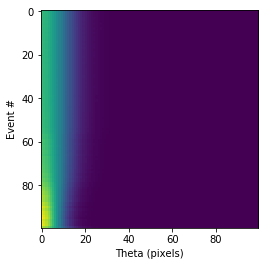

In [17]:
plt.figure(figsize=(12, 4))
plt.imshow(np.sqrt(pdf))
plt.xlabel("Theta (pixels)")
plt.ylabel("Event #")

Now we sample form the 2D PDF along the theta axis:

In [18]:
sample_pdf = InverseCDFSampler(pdf, axis=1)
pix_coord = sample_pdf.sample_axis()

offset = theta_axis.pix_to_coord(pix_coord)

A an additional check we sample from a point source at fixed energy:

In [19]:
N = 100000
energy = np.ones(N) * u.TeV
theta = (theta_axis.center * theta_axis.unit)

coord = {
    "lon": np.zeros(N).reshape(-1, 1),
    "lat": np.zeros(N).reshape(-1, 1),
    "energy": energy.reshape(-1, 1),
    "theta": theta
    
}

pdf = psf_map.psf_map.interp_by_coord(coord)

In [20]:
sample_pdf = InverseCDFSampler(pdf, axis=1)
pix_coord = sample_pdf.sample_axis()
coords = theta_axis.pix_to_coord(pix_coord)

This what the CDF looks like:

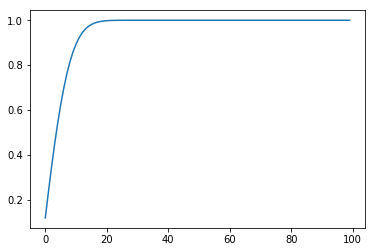

In [21]:
plt.plot(sample_pdf.cdf[0])

Let's check the histogram against the analytical PDF:

(0, 0.2)

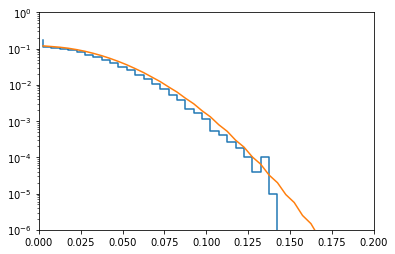

In [24]:
psf_value = psf_3d.evaluate(energy=1 * u.TeV, offset=0 * u.deg, rad=theta)
psf_value = psf_value / psf_value.sum()

psf_hist, vals = np.histogram(coords, theta_axis.edges)
plt.step(theta, psf_hist / psf_hist.sum());
plt.plot(theta, psf_value.squeeze())
plt.semilogy()
plt.ylim(1e-6, 1)
plt.xlim(0, 0.2)